# **Loan Approval Prediction**

## **Dependencies and Data Import**

### **Dependencies**

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('viridis')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [161]:
SEED = 11

In [162]:
file_path_1 = r"C:\Users\Morgan\Documents\My Projects\Kaggle Competitions\Loan Approval Prediction\train.csv"
file_path_2 = r"C:\Users\Morgan\Documents\My Projects\Kaggle Competitions\Loan Approval Prediction\test.csv"

In [163]:
df_train = pd.read_csv(file_path_1)
df_test = pd.read_csv(file_path_2)

## **EDA, Data Cleaning and Visualisation**

### **Data Import**

### **Data Cleaning and EDA**

In [164]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [165]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [166]:
# columns to maintain throughout analysis
test_columns = list(df_test.columns)
train_columns = list(df_train.columns)
# checking for columns in the test set not in train
print(len(test_columns) == len(train_columns) -1)

True


In [167]:
# checking for missing values
df_train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [168]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,58645.0,29322.000000,16929.497605,0.00,14661.00,29322.00,43983.00,58644.00
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


In [169]:
df_train.drop(columns=['id'],inplace=True)

In [170]:
subset = df_train.select_dtypes(['int64','Float64'])

**Ploting Distributions**

In [171]:
def plot_distribution(column):
    sns.histplot(x=column,kde=True,data=subset)
    plt.title(f"The distribution of {column}")
    plt.show();

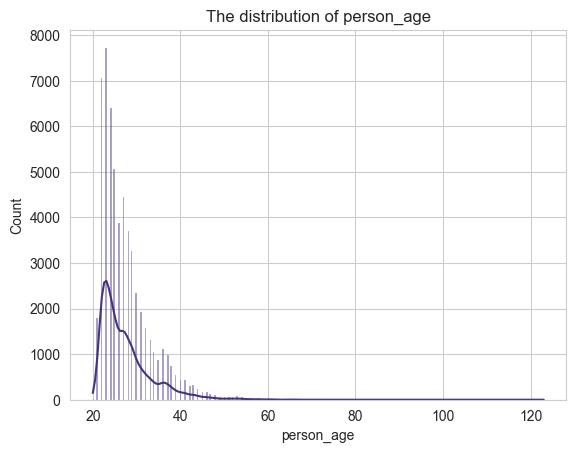

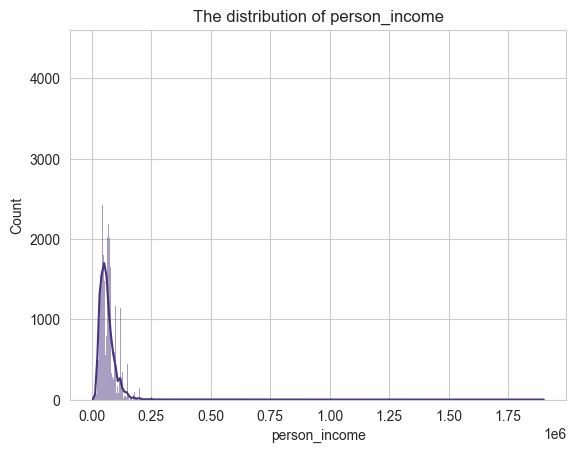

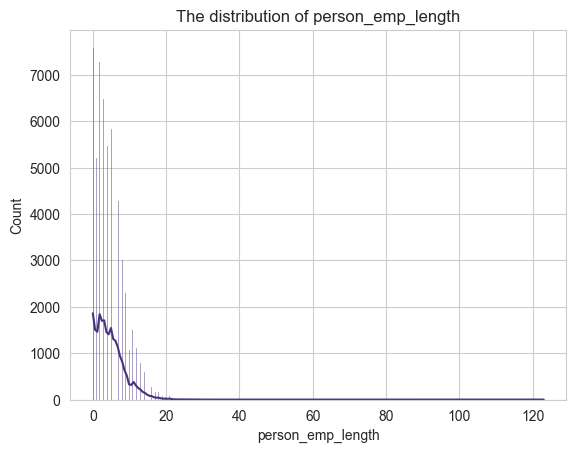

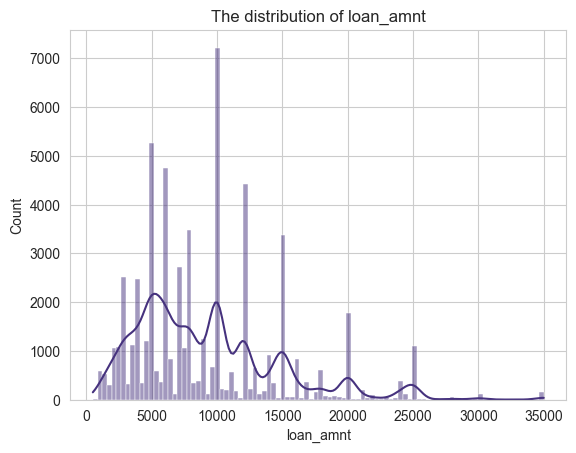

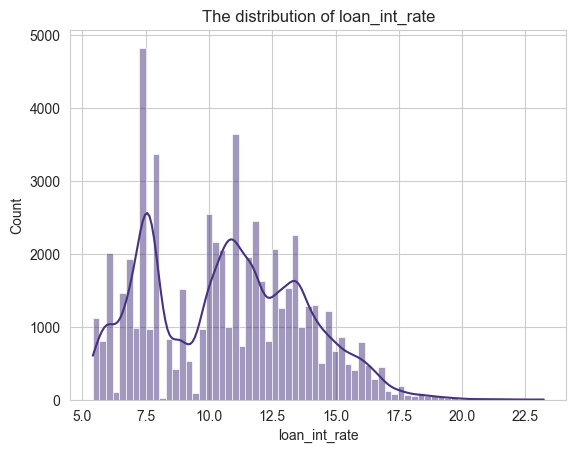

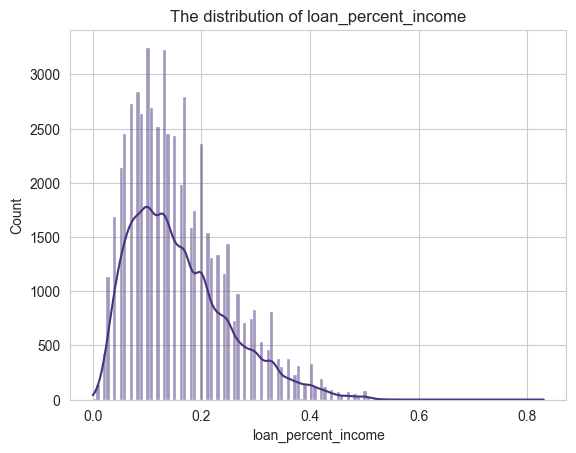

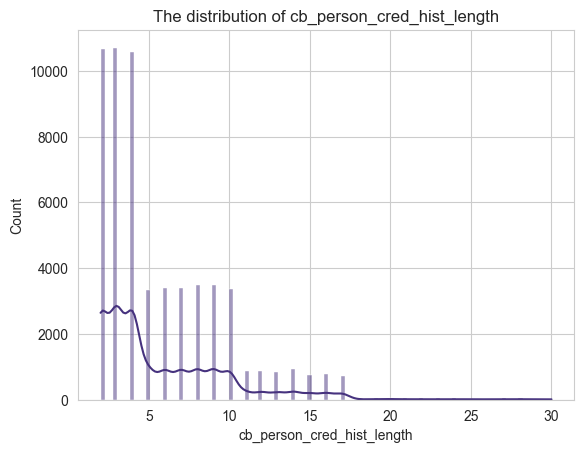

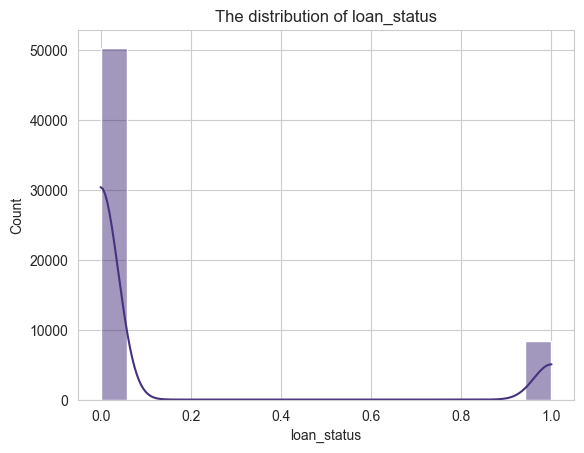

In [172]:
for col in subset:
    plot_distribution(col)

Most of the attributes are right skewed indicating the potential presence of outliers. Checking for outliers using boxplots.

**Outlier detections and treatment**

In [173]:
def outlier_detect(column):
    plt.figure(figsize=(22,6))
    sns.boxplot(data=subset,y=column,hue='loan_status')
    plt.show();

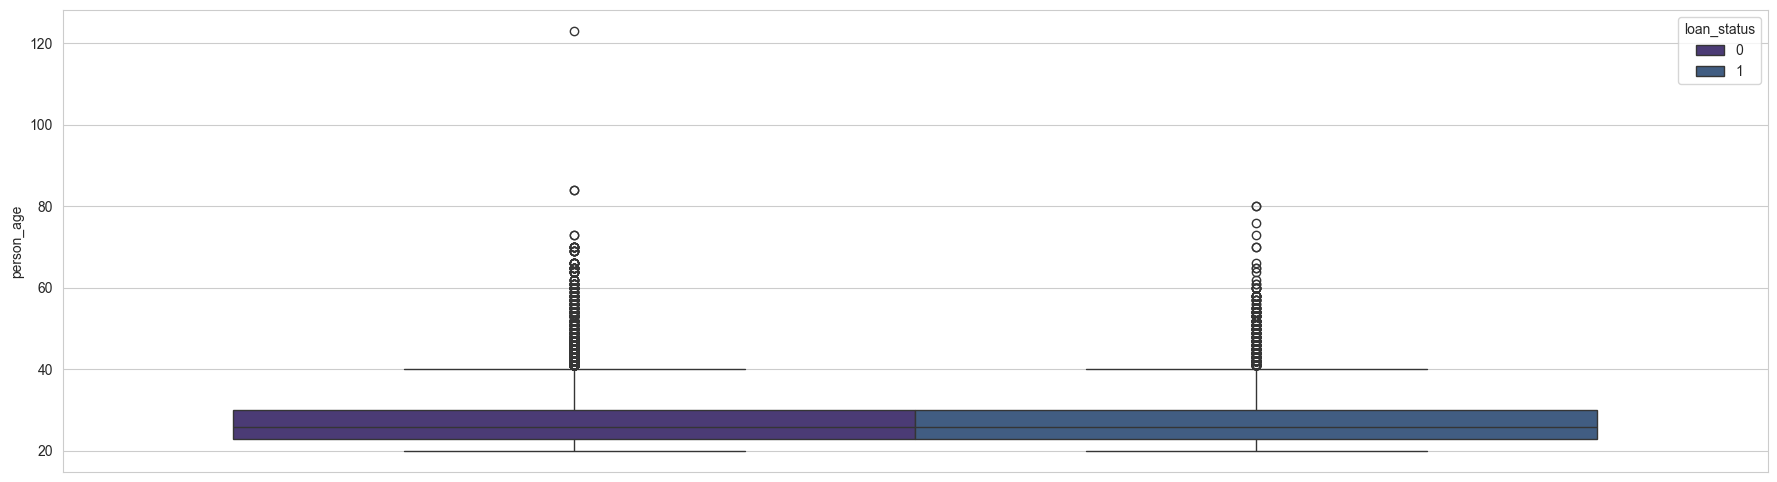

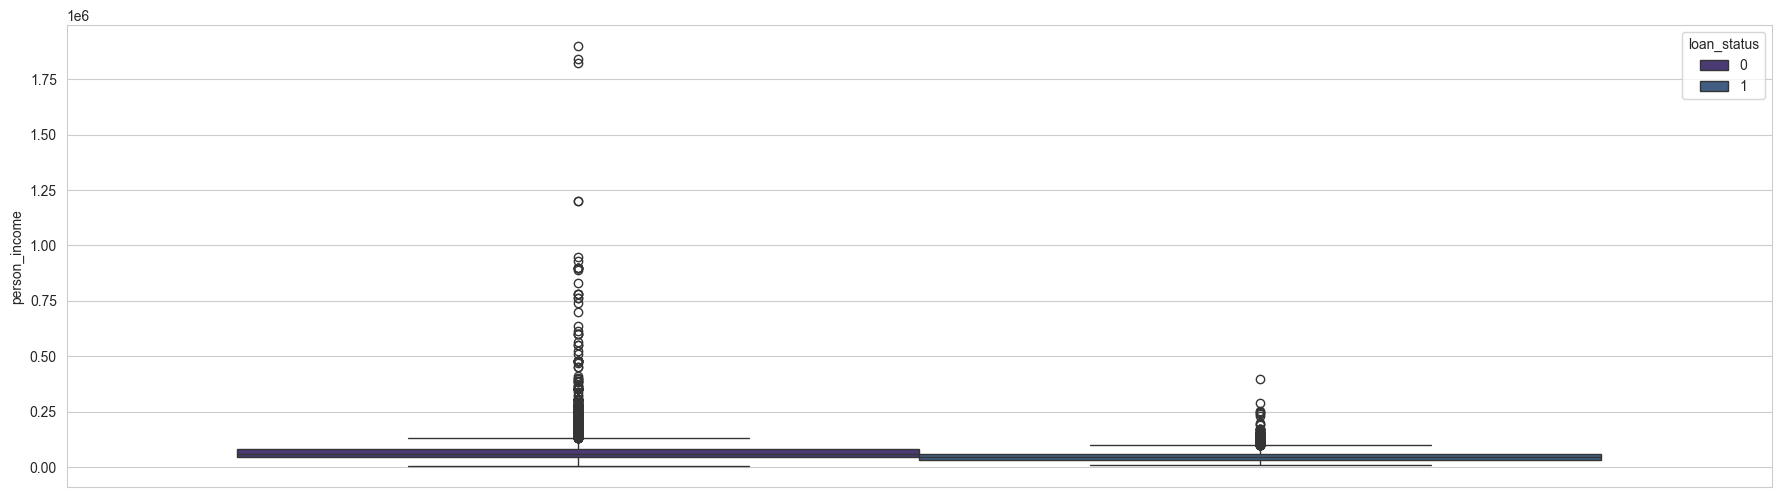

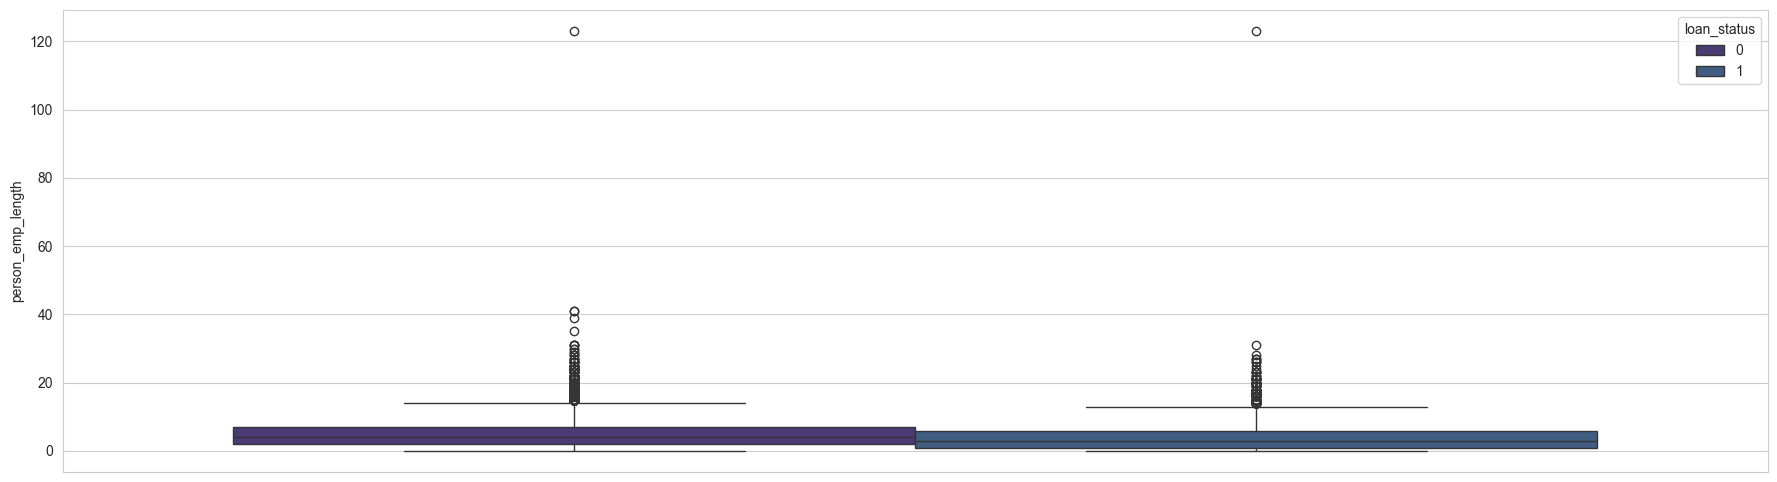

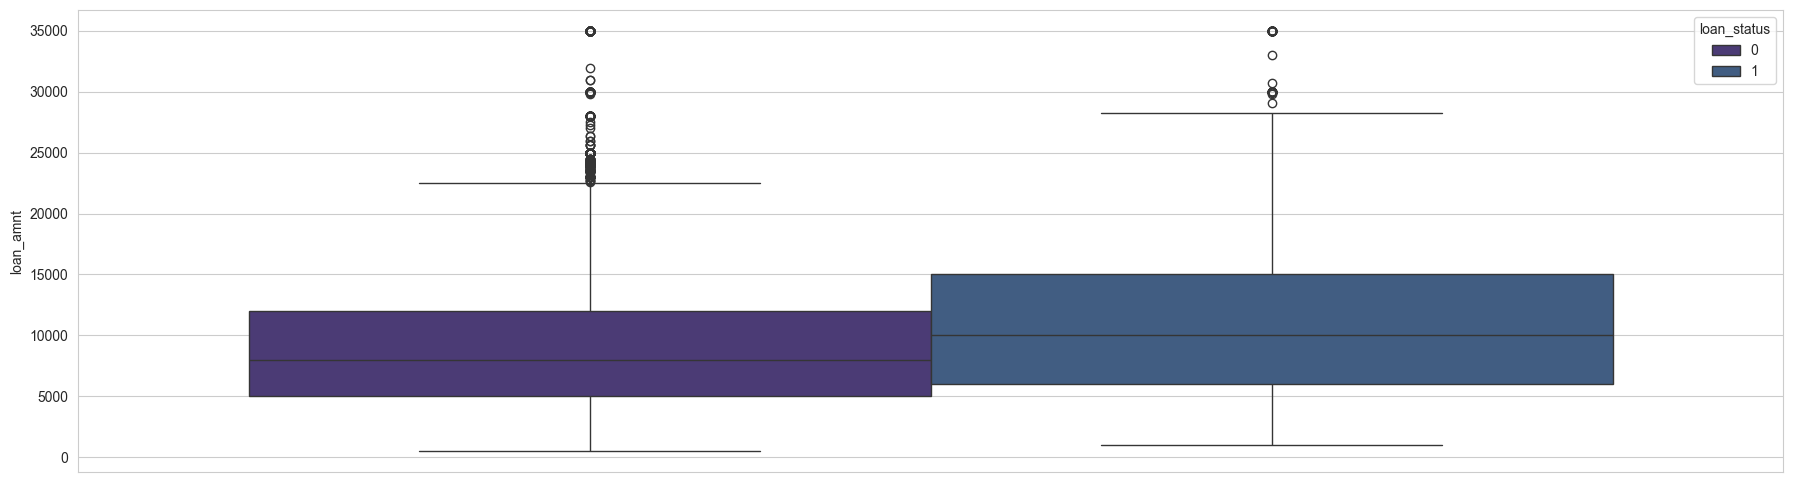

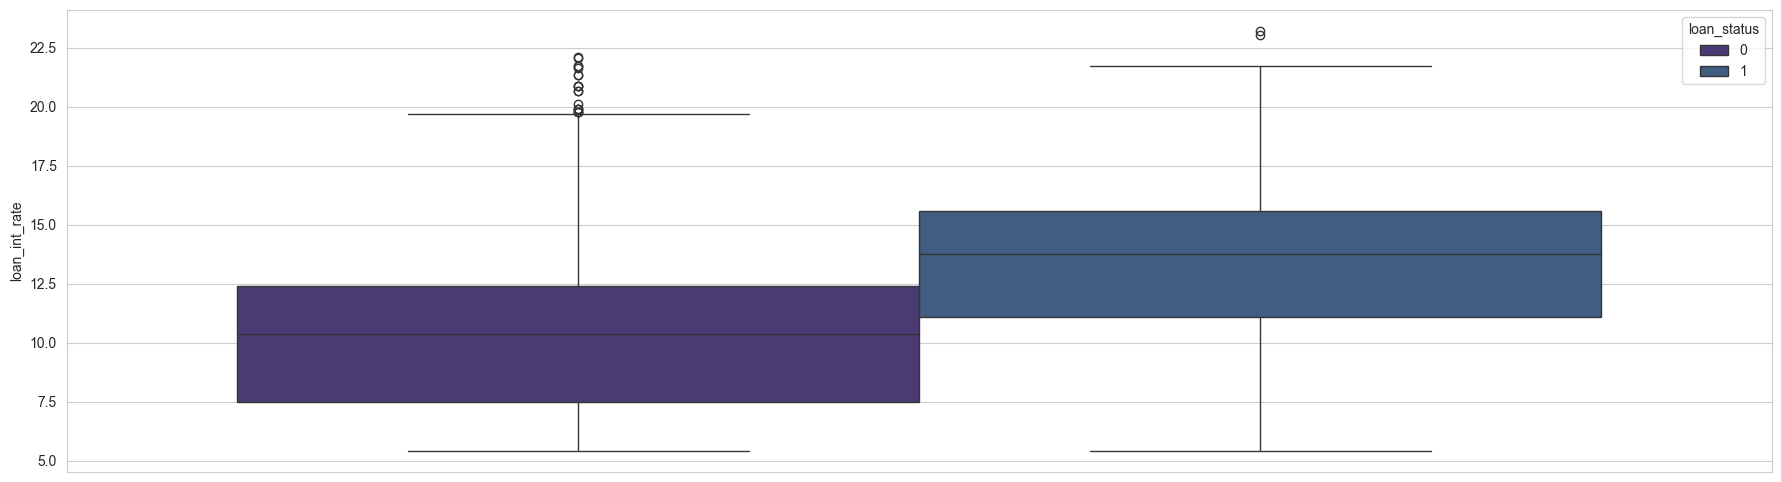

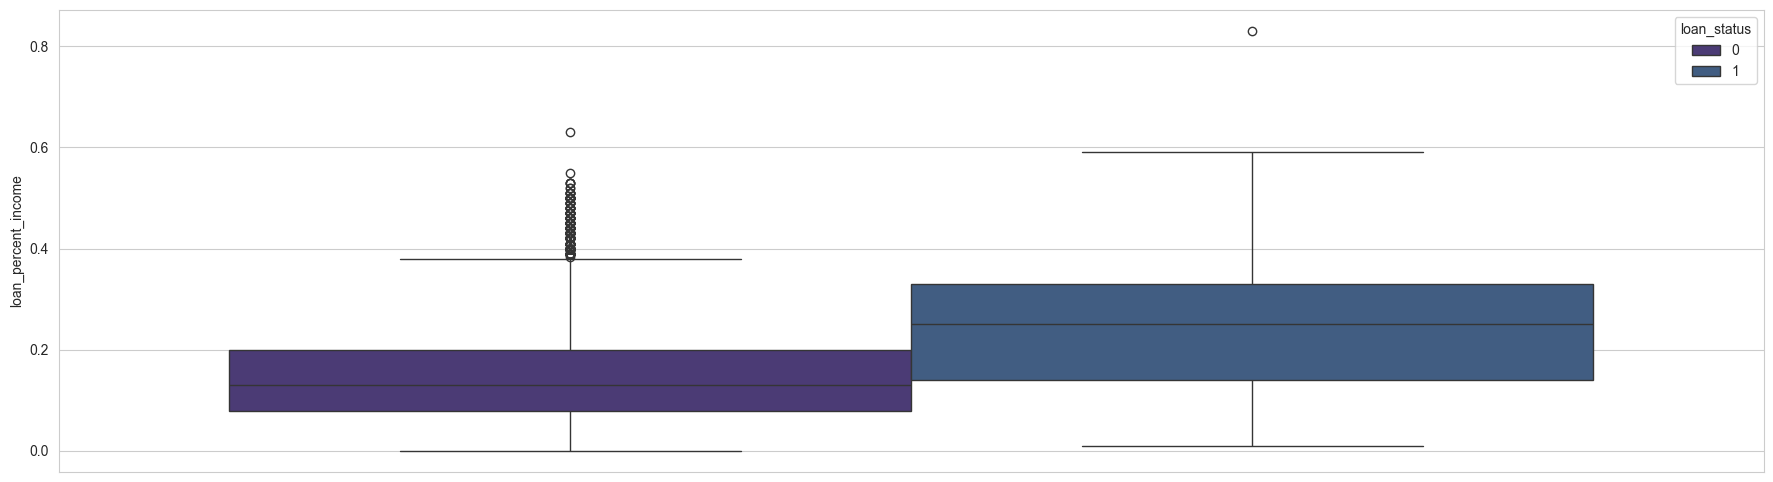

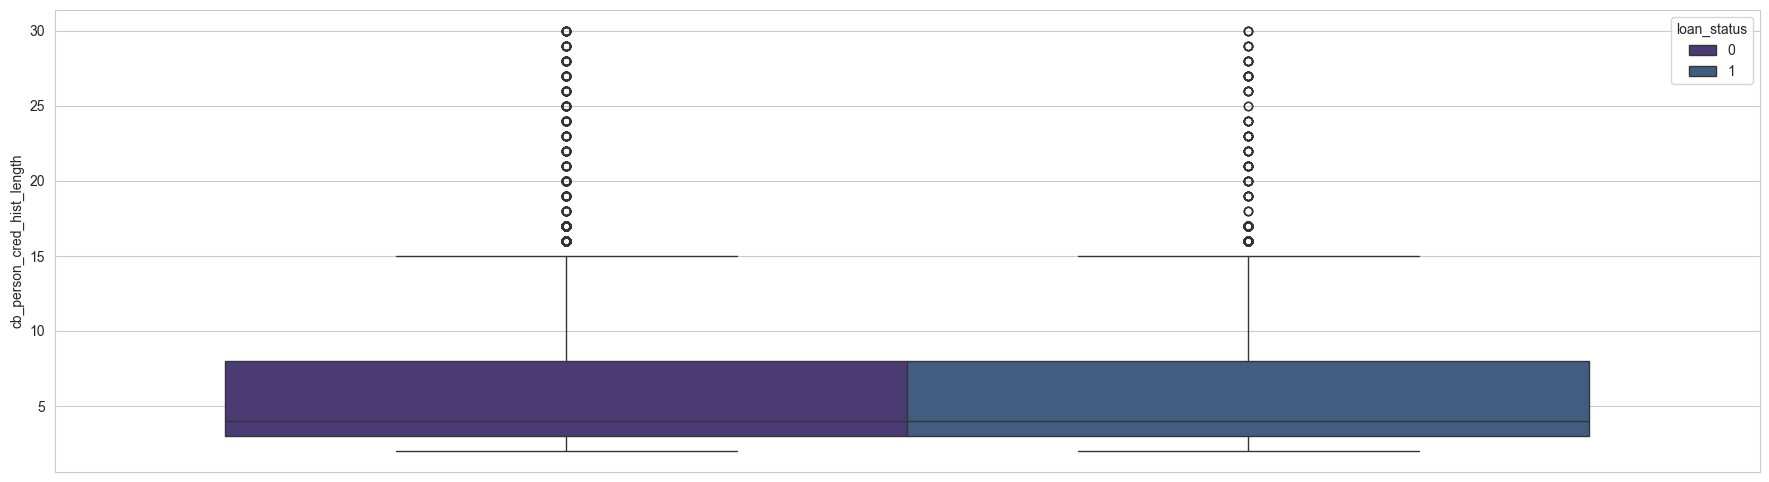

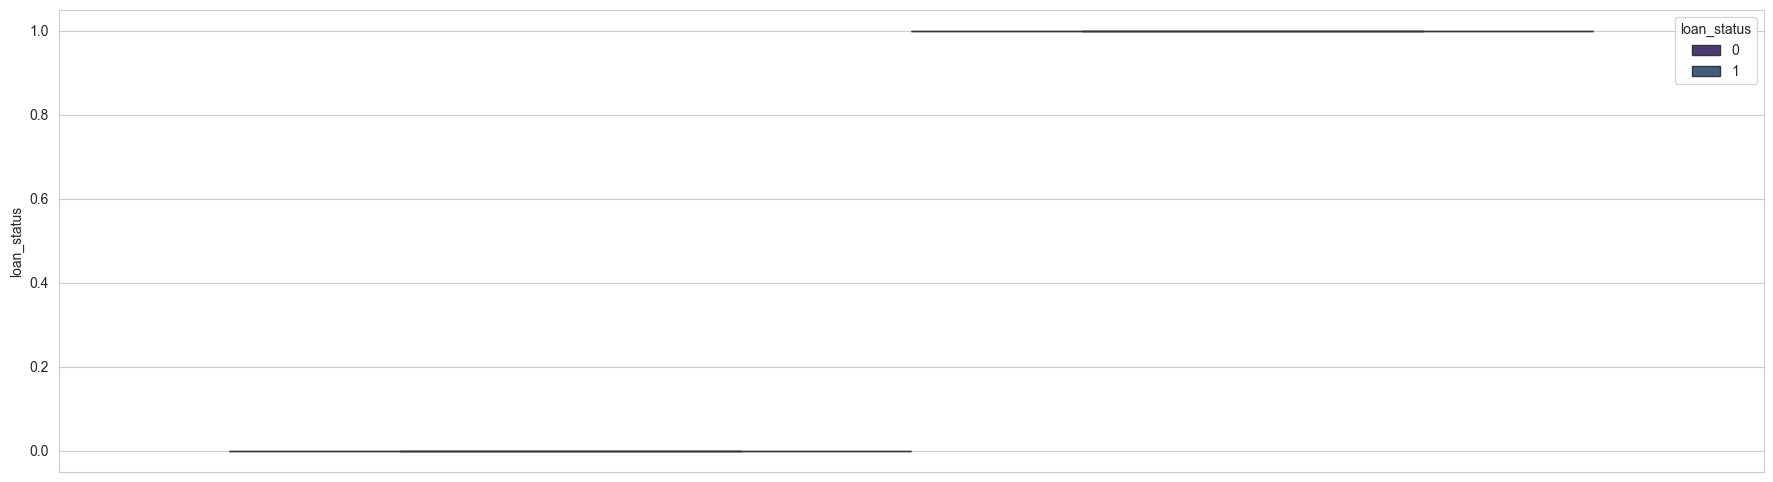

In [174]:
for col in subset:
    outlier_detect(col)

It does not make sense to have an employment length of 123 years or a 123 year old loan applicant.

In [175]:
# dealing with employment length inconsistencies.
df_train = df_train.loc[~(df_train['person_emp_length']>df_train['person_age']),:]
# dropping entry with 123 year old
df_train.drop(df_train.loc[df_train['person_age']==123,:].index,inplace=True)


**Creating categorical columns**

In [176]:
categorical_cols = list(df_train.select_dtypes('object').columns)
for col in categorical_cols:
    df_train[col] = pd.Categorical(df_train[col])

### **Data Visualisation**

In [177]:
def view_category(categorical_column,data=df_train):
    plt.figure(figsize=(22,6))
    ax = sns.countplot(x=categorical_column,data=data,hue='loan_status')
    for p in ax.patches:
        height = int(p.get_height())
        x= p.get_x() + p.get_width()/2
        y = p.get_height()
        if height>0:
            ax.text(x,y,height,va='bottom',ha='center',fontsize=12)
    plt.title(f"Distribution of {categorical_column} by Loan Status")
    plt.xlabel(categorical_column)
    plt.ylabel("")
    plt.yticks([])
    plt.show();

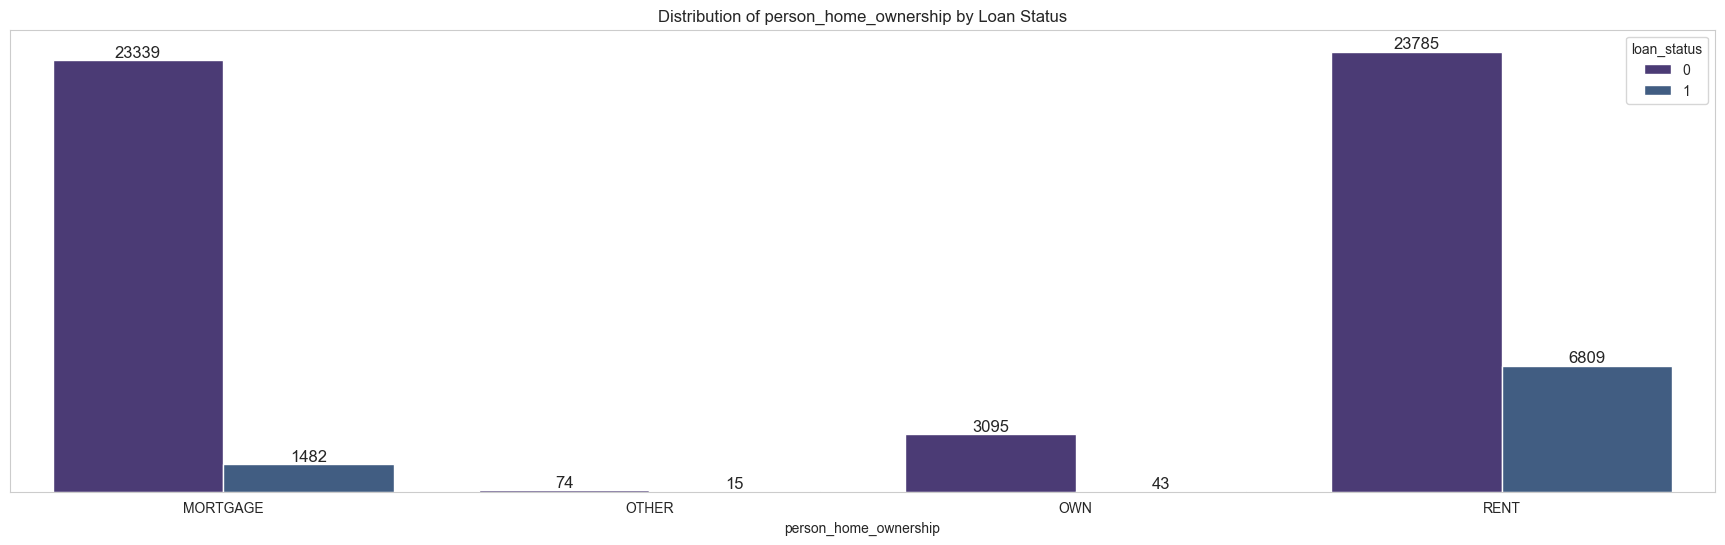

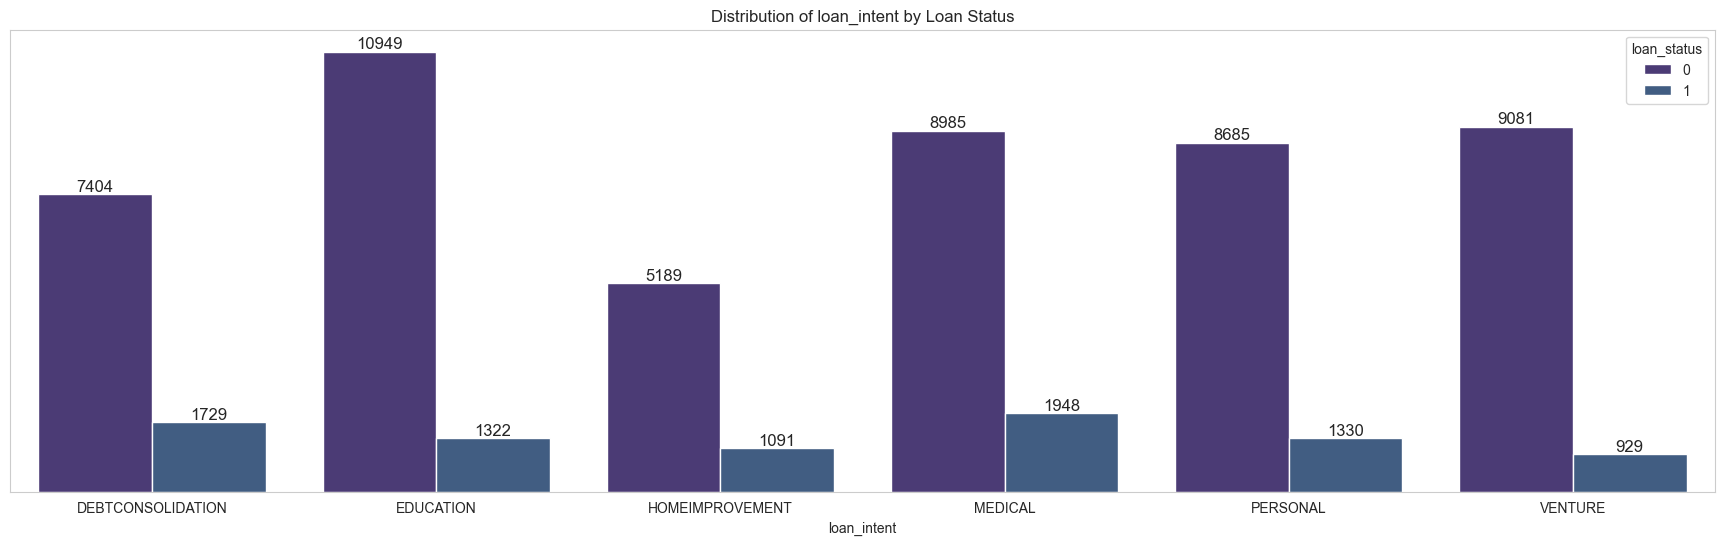

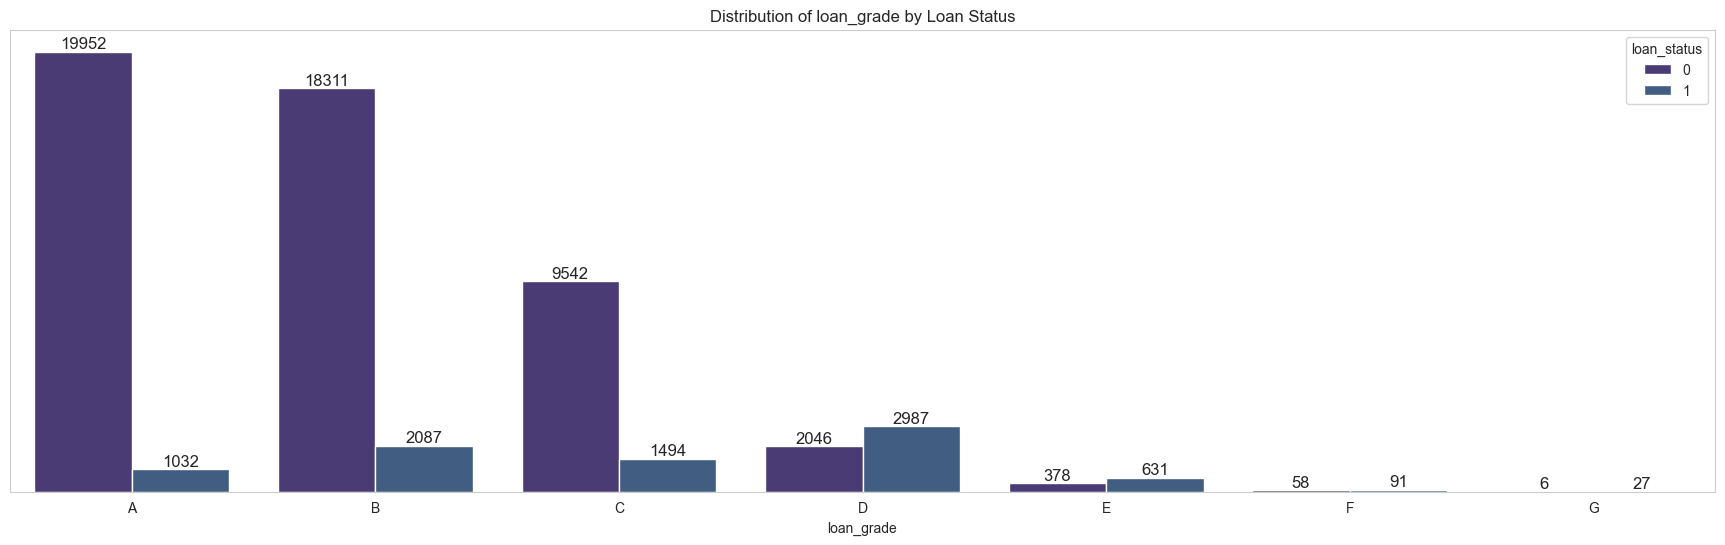

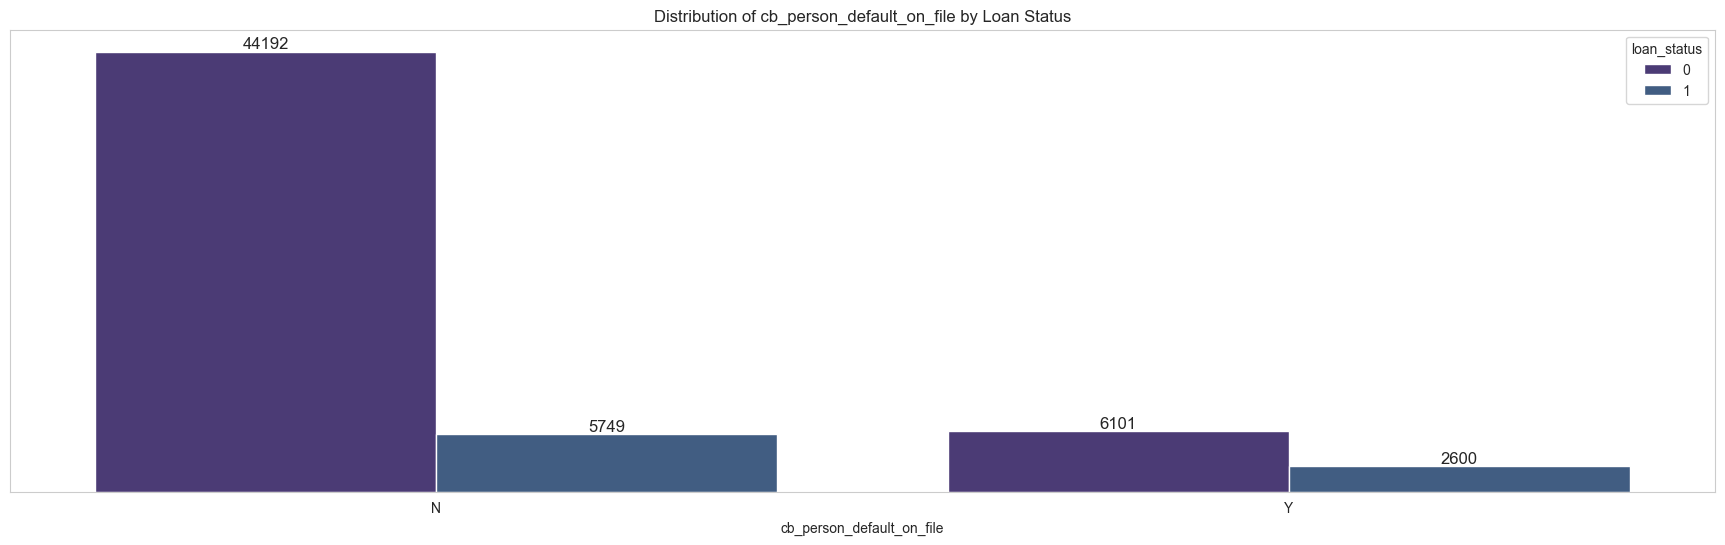

In [178]:
for category in categorical_cols:
    view_category(category)

**Correlation Analysis**

In [179]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [180]:
df_train.dtypes

person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length              float64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file     category
cb_person_cred_hist_length       int64
loan_status                      int64
dtype: object

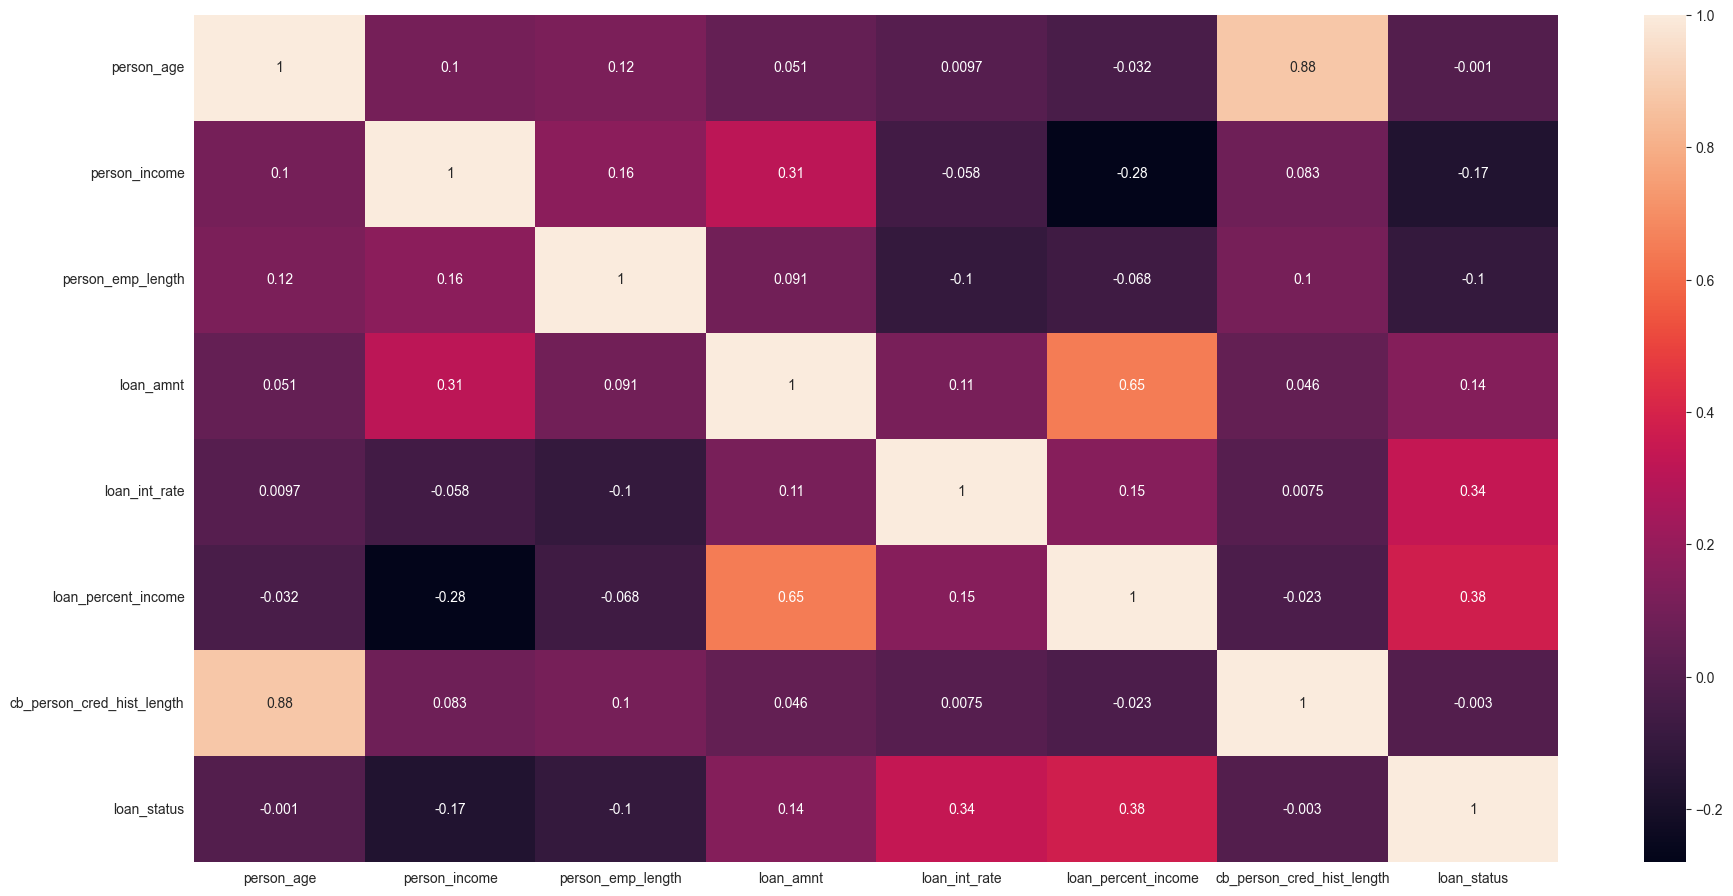

In [181]:
plt.figure(figsize=(22,11))
sns.heatmap(data=df_train.select_dtypes(['int64','float64']).corr(),annot=True)
plt.show();


The dataset exhibits multicollinearity:
- **person_age ↔ cb_person_cred_hist_length (0.876):**
A very strong positive correlation. Older individuals tend to have longer credit histories.
- **loan_amnt ↔ loan_percent_income (0.647):**
Larger loan amounts are associated with a higher percentage of income allocated to loan repayment.

This will affect regression models used in prediction.

| **Feature**                 | **Correlation** | **Impact on Loan Approval**                                                                                         |
|------------------------------|-----------------|---------------------------------------------------------------------------------------------------------------------|
| `loan_percent_income`        | +0.378          | Strongest positive correlation; high loan-to-income ratio loans are more likely to be approved.                     |
| `loan_int_rate`              | +0.339          | Positive correlation; higher-risk loans with higher interest rates tend to be approved.                             |
| `loan_amnt`                  | +0.144          | Positive correlation; larger loans have a slight tendency to be approved.                                           |
| `person_income`              | -0.170          | Negative correlation; higher-income individuals are slightly less likely to get loans approved.                     |
| `person_emp_length`          | -0.103          | Negative correlation; longer employment history has a weak negative association with loan approval.                 |
| `person_age`                 | -0.001          | No correlation; age does not appear to influence loan approval decisions.                                           |
| `cb_person_cred_hist_length` | -0.003          | No correlation; length of credit history has minimal impact on loan approval decisions.                             |


## **Feature Engineering and Model Building**

### **Feature Engineering**

#### **Binning Age**
Age has a very low correlation with loan status approval hence we can attempt to bin it.

**Binning Criteria**:

    - 20-22: Students or recent graduates.
    - 23-27: Early career stage.
    - 28-35: Financially stable mid-career.
    - 36-50: Pre-retirement professionals.
    - 50+: Retirees or nearing retirement.

In [182]:
bins = [0, 22, 27, 35, 50, 100]
labels = ['Under 25', '25-30', '30-40', '40-50', '50+']
df_train['age_bin'] = pd.cut(df_train['person_age'], bins=bins, labels=labels)

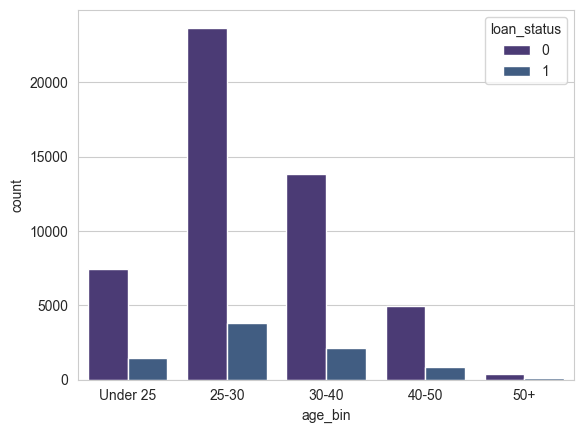

In [183]:
sns.countplot(x='age_bin',data=df_train,hue='loan_status')
plt.show();

#### **Debt and Income**

In [184]:
# new feature, debt to income ratio
df_train['debt_to_income'] = df_train['loan_amnt'] / df_train['person_income']
# non-working years
df_train['non_work_years'] = np.maximum(0,df_train['person_age'] - df_train['person_emp_length'] - 18) # 18 year olds and older are covered by labour laws

### **Model Building**

#### **Data Preprocessing**

In [185]:
# feature encoding
df_train = pd.get_dummies(df_train)
df_train.head()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,debt_to_income,non_work_years,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_bin_Under 25,age_bin_25-30,age_bin_30-40,age_bin_40-50,age_bin_50+
0,37,35000,0.0,6000,11.49,0.17,14,0,0.171429,19.0,...,False,False,False,True,False,False,False,False,True,False
1,22,56000,6.0,4000,13.35,0.07,2,0,0.071429,0.0,...,False,False,False,True,False,True,False,False,False,False
2,29,28800,8.0,6000,8.90,0.21,10,0,0.208333,3.0,...,False,False,False,True,False,False,False,True,False,False
3,30,70000,14.0,12000,11.11,0.17,5,0,0.171429,0.0,...,False,False,False,True,False,False,False,True,False,False
4,22,60000,2.0,6000,6.92,0.10,3,0,0.100000,2.0,...,False,False,False,True,False,True,False,False,False,False


In [186]:
df_train['loan_status'].unique()

array([0, 1], dtype=int64)

In [187]:
numerical_columns = list(df_train.select_dtypes(['int64','Float64']).columns)
print(len(numerical_columns))
numerical_columns.remove('loan_status')
print(len(numerical_columns))

10
9


In [188]:
# feature scaling
scaler = StandardScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])

In [189]:
df_train[numerical_columns]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,debt_to_income,non_work_years
0,1.569782,-0.765783,-1.204620,-0.578277,0.267650,0.117408,2.031742,0.123691,2.174645
1,-0.921760,-0.212101,0.334194,-0.937774,0.880567,-0.973228,-0.946496,-0.937226,-0.856034
2,0.240960,-0.929251,0.847132,-0.578277,-0.585820,0.553662,1.038996,0.515220,-0.377505
3,0.407063,0.157021,2.385947,0.500213,0.142431,0.117408,-0.201937,0.123691,-0.856034
4,-0.921760,-0.106637,-0.691682,-0.578277,-1.238280,-0.646037,-0.698310,-0.634107,-0.537015
...,...,...,...,...,...,...,...,...,...
58640,1.071474,1.475312,0.077725,2.836942,1.737333,0.553662,1.038996,0.515220,0.898570
58641,0.074857,-0.929251,-1.204620,0.140717,0.676262,2.080553,0.542623,1.988717,0.739060
58642,-0.755657,-0.528491,0.590663,-0.434478,1.753809,-0.100719,-0.946496,-0.055425,-0.856034
58643,-0.921760,-0.897612,-0.691682,-0.758025,-0.585820,0.117408,-0.698310,0.073171,-0.537015


In [190]:
# splitting into train and test sets
X = df_train.drop(columns='loan_status')
y = df_train['loan_status']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=SEED,test_size=0.2,stratify=df_train['loan_status'])

#### **Model selection**

In [191]:
models = {
    'Logistic Regression':LogisticRegression(random_state=SEED),
    'K Neighbors Classifier':KNeighborsClassifier(),
    'Random Forest Classifier':RandomForestClassifier(random_state=SEED),
    'Decision Trees':DecisionTreeClassifier(random_state=SEED),
    'XGBoost Classifier':XGBClassifier(),
    'CatBoost':CatBoostClassifier()
}
cv_results_mean = {}
kf = StratifiedKFold(n_splits=3,random_state=SEED,shuffle=True)
for model_name,model in models.items():
    cv_results_mean[model_name] = np.mean(cross_val_score(model,X_train,y_train,cv=kf))
cv_results_mean

Learning rate set to 0.044811
0:	learn: 0.6365415	total: 207ms	remaining: 3m 27s
1:	learn: 0.5881159	total: 241ms	remaining: 2m
2:	learn: 0.5428505	total: 273ms	remaining: 1m 30s
3:	learn: 0.5033978	total: 318ms	remaining: 1m 19s
4:	learn: 0.4684256	total: 372ms	remaining: 1m 14s
5:	learn: 0.4395017	total: 449ms	remaining: 1m 14s
6:	learn: 0.4132014	total: 483ms	remaining: 1m 8s
7:	learn: 0.3900419	total: 501ms	remaining: 1m 2s
8:	learn: 0.3687518	total: 517ms	remaining: 56.9s
9:	learn: 0.3503978	total: 532ms	remaining: 52.7s
10:	learn: 0.3325614	total: 547ms	remaining: 49.2s
11:	learn: 0.3178043	total: 562ms	remaining: 46.3s
12:	learn: 0.3042681	total: 580ms	remaining: 44s
13:	learn: 0.2933800	total: 596ms	remaining: 42s
14:	learn: 0.2827058	total: 613ms	remaining: 40.2s
15:	learn: 0.2741293	total: 631ms	remaining: 38.8s
16:	learn: 0.2657082	total: 648ms	remaining: 37.5s
17:	learn: 0.2584706	total: 666ms	remaining: 36.3s
18:	learn: 0.2518477	total: 683ms	remaining: 35.3s
19:	learn: 0.

{'Logistic Regression': 0.9113251980402061,
 'K Neighbors Classifier': 0.92833542889238,
 'Random Forest Classifier': 0.9499925584200829,
 'Decision Trees': 0.9127107487643803,
 'XGBoost Classifier': 0.9509517767218826,
 'CatBoost': 0.9526996898985919}

Out of box, the XGBoost Classifier, the CatBoost Classifier and the Random Forest Classifier perform the best.

#### **Hyper-parameter tuning**

##### **a. XGBoost Classifier**

In [192]:
xgb_param_grid = {
    'n_estimators': [400],
    'learning_rate': [0.05,0.1],
    'max_depth': [9,10,12],
    'min_child_weight': [3,4,5],
    'subsample': [0.8, 0.9,1],
    'colsample_bytree': [0.8,1.0],
    'gamma': [0.6, 0.8, 1.0],
    'reg_alpha': [0.2, 0.4, 0.6],
    'reg_lambda': [0.1,0.3,0.5],
    'scale_pos_weight': [1, 2],
    'max_delta_step': [0, 1]
}
xgb_classifier = XGBClassifier()
xgb_grid = RandomizedSearchCV(xgb_classifier,param_distributions=xgb_param_grid,n_jobs=1,cv=kf,scoring='accuracy',n_iter=10,random_state=SEED)
# fitting the model
xgb_grid.fit(X_train,y_train)
print(f"Best score :{xgb_grid.best_score_}\n")
print(f"Best parameters:{xgb_grid.best_params_}")

Best score :0.9520602151201797

Best parameters:{'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 0.3, 'reg_alpha': 0.6, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 9, 'max_delta_step': 1, 'learning_rate': 0.05, 'gamma': 0.6, 'colsample_bytree': 0.8}


In [193]:
xgb = XGBClassifier(**xgb_grid.best_params_)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
print(f"The XGBoostClassifier test accuracy is:{accuracy}")

The XGBoostClassifier test accuracy is:0.9516582828885668


##### **b. Random Forest Classifier**

In [194]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_model = RandomForestClassifier(random_state=42)

rf_grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions =rf_param_grid,cv=kf,verbose=2, scoring='accuracy',random_state=SEED,n_jobs=1)

# Fit grid search
rf_grid_search.fit(X_train, y_train)

print(f"Best score :{rf_grid_search.best_score_}\n")
print("Best Parameters:", rf_grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  20.6s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  20.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  21.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100

In [211]:
rf = RandomForestClassifier(**rf_grid_search.best_params_)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_pred,y_test)
print(f"The random forest classifier test accuracy is: {accuracy_rf}")

The random forest classifier test accuracy is: 0.9508056952851905


#### **c. CatBoost Classifier**

In [196]:
param_dist = {
    'iterations': [100, 200, 300, 400],  # Number of boosting iterations
    'depth': [4, 6, 8, 10],               # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1],   # Learning rate for the gradient boosting
    'l2_leaf_reg': [1, 3, 5, 10],         # L2 regularization term
    'subsample': [0.7, 0.8, 0.9, 1.0],    # Fraction of data used for each boosting iteration
    'colsample_bylevel': [0.7, 0.8, 0.9], # Fraction of features to use for each boosting iteration
    'min_data_in_leaf': [1, 5, 10],       # Minimum number of data points in a leaf
    'border_count': [32, 64, 128]         # Number of splits for numerical features
}

# Step 2: Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(cat_features=[], random_state=42, verbose=0)

# Step 3: Initialize RandomizedSearchCV
cat_boost_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,                          # Number of random combinations to test
    scoring='accuracy',                 # Scoring metric (can be changed to 'roc_auc' or other metrics)
    cv=kf,                               # 3-fold cross-validation
    verbose=0,                          # Show progress during the search
    random_state=42,                    # For reproducibility
    )

# Step 4: Fit the RandomizedSearchCV to the data
cat_boost_search.fit(X_train, y_train)

# Step 5: Display the best parameters and score
print(f"Best Score: {cat_boost_search.best_score_}")
print(f"Best Parameters: {cat_boost_search.best_params_}")

Best Score: 0.9525931309889359
Best Parameters: {'subsample': 1.0, 'min_data_in_leaf': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 400, 'depth': 6, 'colsample_bylevel': 0.8, 'border_count': 128}


In [209]:
catb = CatBoostClassifier(**cat_boost_search.best_params_,verbose=0)
catb.fit(X_train,y_train)
y_pred = catb.predict(X_test)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"The categorical boost classifier test accuracy is: {accuracy}")

[0 0 0 ... 0 0 0]
The categorical boost classifier test accuracy is: 0.9530224230539688


##### **c. Ensemble Voting Classifier**

In [ ]:
xgb = XGBClassifier(**xgb_grid.best_params_)
rf = RandomForestClassifier(**rf_grid_search.best_params_)
cat_boost = CatBoostClassifier(**cat_boost_search.best_params_)
voting_clf = VotingClassifier(
    estimators=[
        ('XGBoost',xgb),
        ('RandomForest',rf),
        ('Categorical Boost',cat_boost)
    ],
    voting='soft',
    verbose=0
)
voting_clf.fit(X_train,y_train)
ensemble_score = cross_val_score(voting_clf, X_train, y_train, cv=kf, scoring='accuracy').mean()
print("Ensemble Model Cross validation Accuracy:", ensemble_score)

0:	learn: 0.6307915	total: 32.1ms	remaining: 12.8s
1:	learn: 0.5746224	total: 67.4ms	remaining: 13.4s
2:	learn: 0.5239556	total: 108ms	remaining: 14.3s
3:	learn: 0.4822022	total: 139ms	remaining: 13.8s
4:	learn: 0.4476670	total: 171ms	remaining: 13.5s
5:	learn: 0.4156062	total: 206ms	remaining: 13.5s
6:	learn: 0.3869292	total: 240ms	remaining: 13.5s
7:	learn: 0.3635532	total: 266ms	remaining: 13s
8:	learn: 0.3438991	total: 292ms	remaining: 12.7s
9:	learn: 0.3257762	total: 319ms	remaining: 12.4s
10:	learn: 0.3103954	total: 351ms	remaining: 12.4s
11:	learn: 0.2964964	total: 380ms	remaining: 12.3s
12:	learn: 0.2847692	total: 409ms	remaining: 12.2s
13:	learn: 0.2743487	total: 431ms	remaining: 11.9s
14:	learn: 0.2656309	total: 457ms	remaining: 11.7s
15:	learn: 0.2576421	total: 512ms	remaining: 12.3s
16:	learn: 0.2505641	total: 536ms	remaining: 12.1s
17:	learn: 0.2438344	total: 559ms	remaining: 11.9s
18:	learn: 0.2382838	total: 585ms	remaining: 11.7s
19:	learn: 0.2328641	total: 608ms	remaini

In [ ]:
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
print(f"The Ensemble Model Test Accuracy is: {accuracy}")

The Ensemble Model Test Accuracy is: 0.9531076818143064


#### **d. Stacking Voting Classifier**

In [ ]:
xgb = XGBClassifier(**xgb_grid.best_params_)
rf = RandomForestClassifier(**rf_grid_search.best_params_)
cat_boost = CatBoostClassifier(**cat_boost_search.best_params_)
stacking_clf = StackingClassifier(
    estimators=[
        ('XGBoost',xgb),
        ('RandomForest',rf),
        ('Categorical Boost',cat_boost)
    ],
    verbose=0,
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train,y_train)
ensemble_score = cross_val_score(stacking_clf,X_train,y_train,cv=kf,scoring='accuracy').mean()
print("Ensemble Model Cross Validation Accuracy:", ensemble_score)

0:	learn: 0.6307915	total: 54.3ms	remaining: 21.7s
1:	learn: 0.5746224	total: 99.6ms	remaining: 19.8s
2:	learn: 0.5239556	total: 145ms	remaining: 19.1s
3:	learn: 0.4822022	total: 187ms	remaining: 18.5s
4:	learn: 0.4476670	total: 232ms	remaining: 18.3s
5:	learn: 0.4156062	total: 265ms	remaining: 17.4s
6:	learn: 0.3869292	total: 292ms	remaining: 16.4s
7:	learn: 0.3635532	total: 316ms	remaining: 15.5s
8:	learn: 0.3438991	total: 341ms	remaining: 14.8s
9:	learn: 0.3257762	total: 364ms	remaining: 14.2s
10:	learn: 0.3103954	total: 387ms	remaining: 13.7s
11:	learn: 0.2964964	total: 410ms	remaining: 13.3s
12:	learn: 0.2847692	total: 433ms	remaining: 12.9s
13:	learn: 0.2743487	total: 455ms	remaining: 12.5s
14:	learn: 0.2656309	total: 477ms	remaining: 12.3s
15:	learn: 0.2576421	total: 499ms	remaining: 12s
16:	learn: 0.2505641	total: 522ms	remaining: 11.8s
17:	learn: 0.2438344	total: 545ms	remaining: 11.6s
18:	learn: 0.2382838	total: 568ms	remaining: 11.4s
19:	learn: 0.2328641	total: 588ms	remaini

In [ ]:
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
print(f"The Ensemble Model Test Accuracy is: {accuracy}")

The Ensemble Model Test Accuracy is: 0.9525961292522807


**The majority voting ensemble has the highest test accuracy hence we can expect it should generalise well to unseen data**

### **Feature Importance**

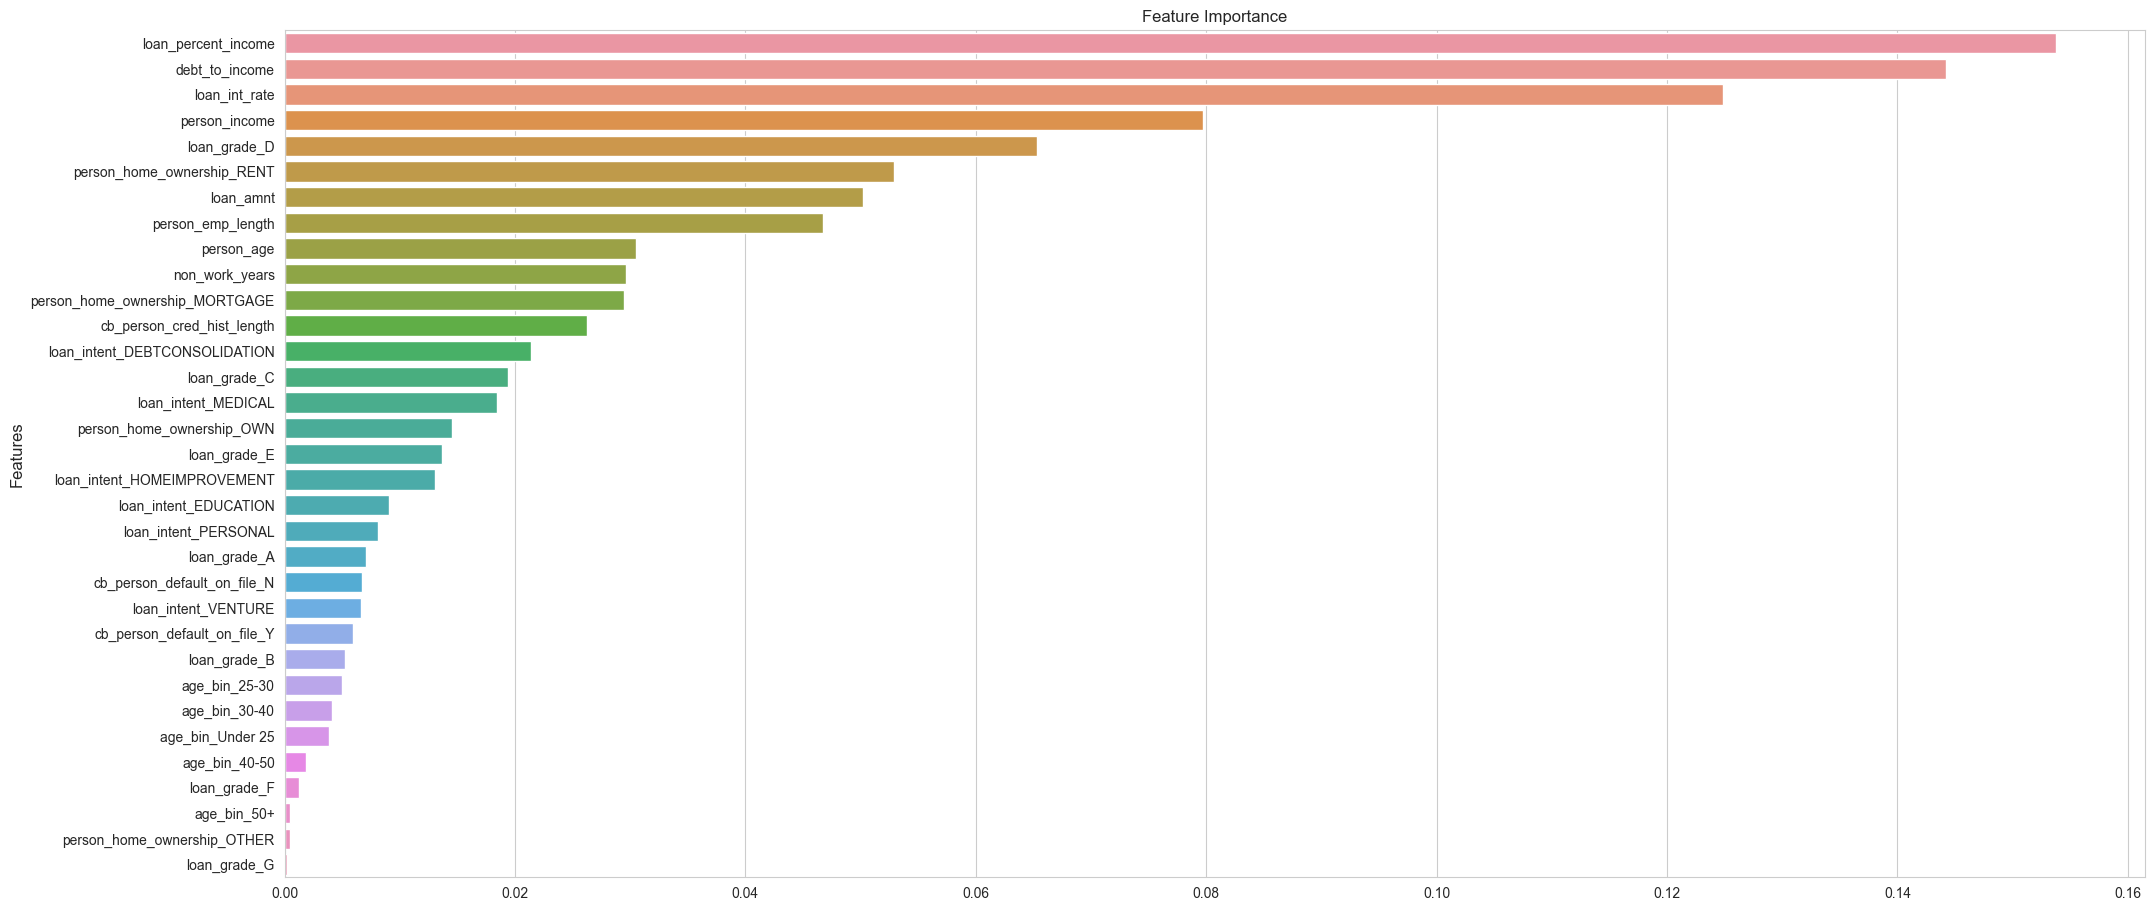

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
important_features = pd.Series(rf.feature_importances_,index=X.columns)
rf_sorted_features = important_features.sort_values(ascending=False)
plt.figure(figsize=(24,11))
sns.barplot(y=rf_sorted_features.index,x=rf_sorted_features.values)
plt.ylabel('Features',fontsize=12)
plt.title("Feature Importance")
plt.show();

#### **Saving the model**

In [ ]:
import joblib
joblib.dump(voting_clf,'Voting Classifier.pkl')

['Voting Classifier.pkl']

## **Predictions on test dataset**

In [ ]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


**Data Transformation**

In [ ]:
def transform_test_data(dataframe):
    bins = [0, 22, 27, 35, 50, 100]
    labels = ['Under 25', '25-30', '30-40', '40-50', '50+']
    
    # Creating age_bin
    dataframe['age_bin'] = pd.cut(dataframe['person_age'], bins=bins, labels=labels)
    
    # New feature: debt-to-income ratio
    dataframe['debt_to_income'] = dataframe['loan_amnt'] / dataframe['person_income']
    
    # New feature: non-working years
    dataframe['non_work_years'] = np.maximum(0, dataframe['person_age'] - dataframe['person_emp_length'] - 18)
    test_index = dataframe['id']
    
    # Converting categorical variables to dummy variables
    dataframe = pd.get_dummies(dataframe)
    
    # Feature scaling for numerical columns
    numerical_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])
    
    # Extracting test index and dropping 'id' column
    X = dataframe.drop('id', axis=1)
    
    # Load pre-trained model
    model = joblib.load('Voting Classifier.pkl')
    
    # Predict loan status
    loan_status = model.predict(X)
    
    # Creating submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_index,
        'loan_status': loan_status
    })
    submission_df.to_csv('loan_approval_submission.csv',index=False)

    return submission_df

In [ ]:
transform_test_data(df_test)

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


**Prediction**

In [ ]:
model = joblib.load('Voting Classifier.pkl')
loan_status = model.predict(X)
loan_status

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)